Напишем функцию детектирования лиц

In [1]:
import numpy as np
import mtcnn
from mtcnn.mtcnn import MTCNN
from PIL import Image
from matplotlib import pyplot
%matplotlib inline

def extract_face(filename, required_size=(224,224),resize=False):
    pixels=pyplot.imread(filename)
    detector=MTCNN()
    results=detector.detect_faces(pixels)
    x1,y1,widht,height = results[0]['box']
    x2,y2=x1+widht,y1+height
    face=pixels[y1:y2,x1:x2]
    image=Image.fromarray(face)
    if resize:
        image=image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def print_image(img):
    if isinstance(img,str):
        img=pyplot.imread(img)
    pyplot.imshow(img)
    pyplot.show()

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dropout, Activation, Dense

Архитектура сверточной нейронной сети VGGface

In [3]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

Загружаем готовые весовые коэфициенты

In [4]:
from keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')

Фиксируем значение весов во всех слоях, кроме последнего. 

In [5]:
final_layer = Dense(2, activation='softmax')(model.layers[-2].output) 

model = Model(model.inputs,final_layer)
for layer in model.layers[:-1]:
    layer.trainable = False

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Сетка модели

In [7]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)     

In [8]:
import os

In [9]:
dir1="DataSet//Alexey"
dir2="DataSet//Daniil"


file1=os.listdir(dir1)
file2=os.listdir(dir2)

In [10]:
images1=[extract_face(os.path.join(dir1,i),resize=True)for i in file1]
images2=[extract_face(os.path.join(dir2,i),resize=True)for i in file2]

In [11]:
X_train=images1[:-12]+images2[:-12]
Y_train=[[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],     
         [0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]

X_test=images1[-12:]+images2[-12:]
Y_test=[[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],          
         [0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]



Изменение положение объекта исследования в кадре

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. /255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale= 1. /255)

In [13]:
train=train_datagen.flow(np.asarray(X_train),np.asarray(Y_train))

In [14]:
model.fit_generator(train,epochs=50,verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
1/1 - 0s - loss: 0.6919 - accuracy: 0.5000
Epoch 2/50
1/1 - 0s - loss: 0.6799 - accuracy: 0.8462
Epoch 3/50
1/1 - 0s - loss: 0.6686 - accuracy: 0.9615
Epoch 4/50
1/1 - 0s - loss: 0.6561 - accuracy: 1.0000
Epoch 5/50
1/1 - 0s - loss: 0.6465 - accuracy: 1.0000
Epoch 6/50
1/1 - 0s - loss: 0.6326 - accuracy: 1.0000
Epoch 7/50
1/1 - 0s - loss: 0.6215 - accuracy: 1.0000
Epoch 8/50
1/1 - 0s - loss: 0.6127 - accuracy: 1.0000
Epoch 9/50
1/1 - 0s - loss: 0.6069 - accuracy: 1.0000
Epoch 10/50
1/1 - 0s - loss: 0.5947 - accuracy: 1.0000
Epoch 11/50
1/1 - 0s - loss: 0.5755 - accuracy: 1.0000
Epoch 12/50
1/1 - 0s - loss: 0.5674 - accuracy: 1.0000
Epoch 13/50
1/1 - 0s - loss: 0.5605 - accuracy: 1.0000
Epoch 14/50
1/1 - 0s - loss: 0.5478 - accuracy: 1.0000
Epoch 15/50
1/1 - 0s - loss: 0.5374 - accuracy: 1.0000
Epoch 16/50
1/1 - 0s - loss: 0.5246 - accuracy: 1.0000
Epoch 17/50
1/1 - 0s - loss: 0.5166 - accuracy: 1.000

In [15]:
predicted = model.predict(np.asarray(X_test))

Результаты распознавания

In [16]:
print(Y_test)
print(predicted)

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
[[1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 3.0082115e-10]
 [1.0000000e+00 3.7303899e-08]
 [1.0000000e+00 2.3675394e-14]
 [1.0000000e+00 3.9578730e-13]
 [1.0000000e+00 5.8985332e-08]]


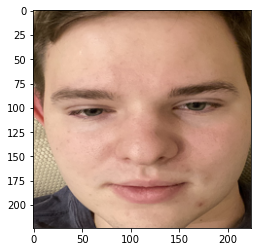

In [17]:
pyplot.imshow(Image.fromarray(X_test[0]))

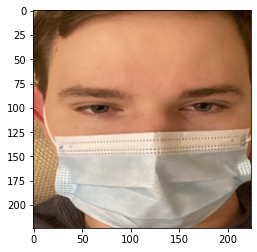

In [18]:
pyplot.imshow(Image.fromarray(X_test[11]))

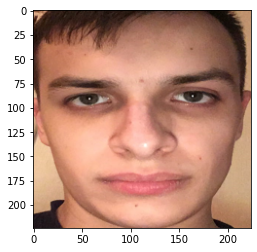

In [19]:
pyplot.imshow(Image.fromarray(X_test[15]))

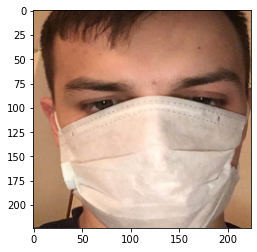

In [20]:
pyplot.imshow(Image.fromarray(X_test[20]))

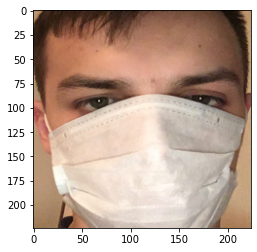

In [21]:
pyplot.imshow(Image.fromarray(X_test[23]))